In [1]:
#!pip install translate

In [2]:
#%matplotlib inline
from IPython.display import clear_output
from datetime import date
from datetime import timedelta
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.dates import date2num, num2date
from matplotlib.patches import Patch
from scipy import stats as sps
from scipy.interpolate import interp1d
from scipy.special import gammaincinv
from scipy.stats import rv_continuous, gamma, nbinom
from statsmodels.nonparametric.smoothers_lowess import lowess
from translate import Translator
from typing import Optional, List, Iterable
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la
import warnings
warnings.filterwarnings('ignore')
translator= Translator(from_lang="english",to_lang="russian")

# Первая часть

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

(70, 4)


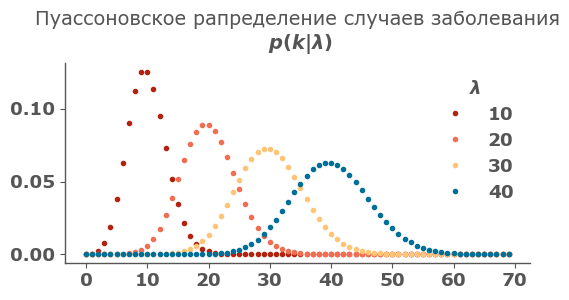

In [4]:
# Вектор от k
k = np.arange(0, 70)[:, None]
# Different values of Lambda
lambdas = [10, 20, 30, 40]
# Оцениваем функцию массы вероятности (помнитм, что распределение Пуассона является дискретным).
y = sps.poisson.pmf(k, lambdas)

# Показываем результат
print(y.shape)
fig, ax = plt.subplots(figsize=(6,2.5))
ax.set(title='Пуассоновское рапределение случаев заболевания\n $p(k|\lambda)$')
plt.plot(k, y, marker = 'o', markersize = 3, lw =0)
plt.legend(title = "$\lambda$", labels = lambdas);

Распределение Пуассона гласит, что если мы думаем, что у вас будет 𝜆 случаев в день, то, вероятнее всего, получим столько же, плюс-минус некоторое колебание, основанное на случайности.

Но в нашем случае мы знаем, что произошло 𝑘 случаев, и нам нужно узнать, какое значение 𝜆 наиболее вероятно. Для этого мы фиксируем значение 𝑘, в то время как меняем 𝜆. Это называется функцией правдоподобия.

Например, мы наблюдаем 20 новых случаев 𝑘, и мы хотим знать, насколько вероятно каждое значение 𝜆:

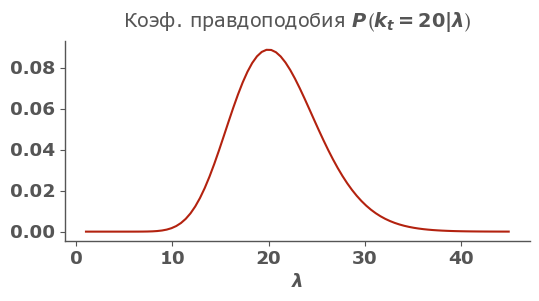

In [5]:
k = 20
lam = np.linspace(1, 45, 90)
likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')
likelihood.plot(title=r'Коэф. правдоподобия $P\left(k_t=20|\lambda\right)$', figsize=(6,2.5));

Это означает, что если мы видим 20 случаев, наиболее вероятным значением $\lambda$ является, очевидно, 20. Но мы не уверены: возможно, $\lambda$ была равна 21 или 17, и мы увидели 20 новых случаев только благодаря случайности. Это также означает, что маловероятно, что $\lambda$ была равна 40, и мы увидели 20 случаев.

__Реализуем связь $R_t$ и $\lambda$__.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

где $\gamma$ является обратным значением интервала инкубации ([примерно 7 дней для COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)). Поскольку мы знаем все новые случаи на вчерашний день, мы теперь можем представить функцию правдоподобия как параметр Пуассона, параметризованный фиксированным значением $k$ и изменяющим $R_t$.

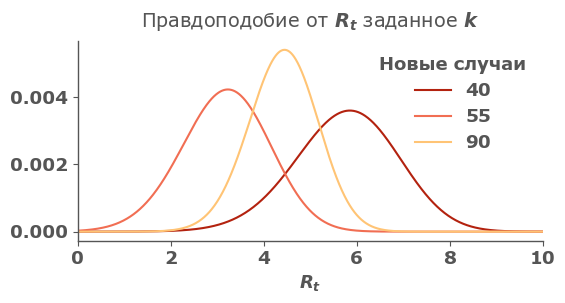

In [6]:
k = np.array([20, 40, 55, 90])

# Создаем массив со всеми возможными значениями Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Гамма равна 1/серийный интервал
GAMMA = 1/7

# Отобразим Rt на лямбда-функцию, чтобы мы могли подставить его в уравнение ниже.
# Обратим внимание, что у нас есть N-1 лямбд, то есть на первый день вспышки мы не знаем, чего ожидать.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Оценим вероятность на каждый день и нормализуем сумму каждого дня к 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Отобразим на графике
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Правдоподобие от $R_t$ заданное $k$',
    xlim=(0,10),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='Новые случаи')
ax.set_xlabel('$R_t$');

Есть независимые предположения для $R_t$ на каждый день. Цель состоит в том, чтобы объединить информацию, которую мы имеем о предыдущих днях с текущим днем. Для этого мы используем теорему Байеса.

### Выполнение Байесовского вывода

Для выполнения байесовского вывода мы должны умножить правдоподобие на априорное распределение (которое представляет собой только правдоподобие вчерашнего дня без нашего гауссовского распределения), чтобы получить апостериорные распределения. Давайте сделаем это с помощью кумулятивного произведения каждого последующего дня.

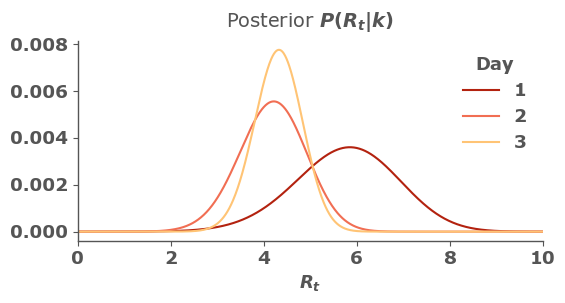

In [7]:
# Вычисляем постериорные вероятности для каждого значения R_t
posteriors = likelihood_r_t.cumprod(axis=1)
# Нормализуем вероятности
posteriors = posteriors / np.sum(posteriors, axis=0)

# Создаем таблицу с вероятностями
columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

# Выводим график с постериорными вероятностями
ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

На первый день апостериорная вероятность соответствует первому дню показателя правдоподобия сверху. Это потому, что у нас нет никакой информации, кроме этого дня. Однако, когда мы обновляем априорное распределение, используя информацию со второго дня, мы видим, что кривая сместилась влево, но не так сильно, как и правдоподобие со второго дня и выше. Это происходит потому, что байесовский вывод использует информацию обоих дней и эффективно усредняет их. Поскольку правдоподобие от третьего дня лежит между двумя другими, вы видите небольшое смещение вправо, но главное: узкое распределение. Мы становимся более уверенными в наших убеждениях в истинное значение $R_t$.

In [8]:
most_likely_values = posteriors.idxmax(axis = 0)

Получаем интервалы максимальной плотности для $R_t$:

In [9]:
def highest_density_interval(pmf, p=.9, debug=False):
    # При передаче датафрейма, вызываем рекурсивно его столбцы
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N матрица общей вероятностной массы
    total_p = cumsum - cumsum[:, None]
    
    # Возвращаем все индексы total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Ищем наименьший диапазон (наибольшую плотность)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


Строим историю изменения наших убеждений относительно наиболее вероятных значений  𝑅𝑡  и интервалов высокой плотности вероятности (ИЧР) со временем. 
Это наиболее полезное представление, поскольку оно показывает, как наши убеждения меняются каждый день.

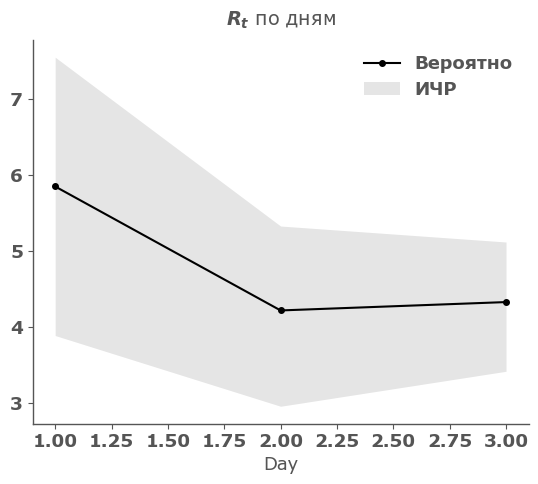

In [10]:
ax = most_likely_values.plot(marker='o',
                             label='Вероятно',
                             title=f'$R_t$ по дням',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='ИЧР')

ax.legend();

Наиболее вероятное значение $R_t$ меняется с течением времени, а интервал наивысшей плотности сужается, по мере того, как мы становимся более уверенными в истинном значении $R_t$. Обратите внимание, что поскольку у нас было всего четыре дня истории, я не применял гауссовский процесс к этой выборке. Однако далее мы обратимся к реальному примеру, где этот процесс необходим.

In [11]:
states = pd.read_csv("new.csv",
                     usecols=['date', 'location', 'total_cases'],
                     index_col=['location', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()
states.rename_axis(index={'location': 'state'}, inplace=True)
states.rename('cases', inplace=True)

state    date      
Germany  2020-01-27        1.0
         2020-01-28        4.0
         2020-01-29        4.0
         2020-01-30        4.0
         2020-01-31        5.0
                        ...   
Italy    2020-03-10    10149.0
         2020-03-11    12462.0
         2020-03-12    15113.0
         2020-03-13    17660.0
         2020-03-14    21157.0
Name: cases, Length: 92, dtype: float64

In [12]:
wuhan = pd.read_csv("wuhan.csv",
                    usecols=['date', 'location', 'cases'],
                    index_col=['location', 'date'],
                    parse_dates=['date'],
                    squeeze=True).sort_index()
wuhan.rename_axis(index={'location': 'state'}, inplace=True)
wuhan = wuhan.astype(float)
#wuhan.rename('cases', inplace=True)

Рассматривая состояние, мы должны начать анализ с того момента, когда количество случаев станет достаточно стабильным каждый день. Ищем последний день, когда не было новых случаев, и начинаем анализ со следующего дня.

Также следует отметить, что отчетность о случаях может быть непостоянной в зависимости от задержек в тестировании, и т.д. Чтобы получить наилучшие данные, я применил гауссовский фильтр к временному ряду. Конечно, это произвольный выбор, но можно предположить, что реальный процесс не настолько случаен, как сама отчетность.

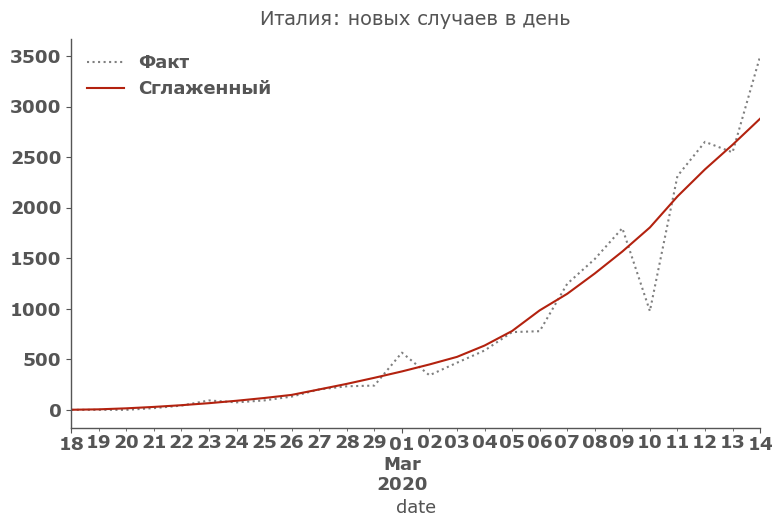

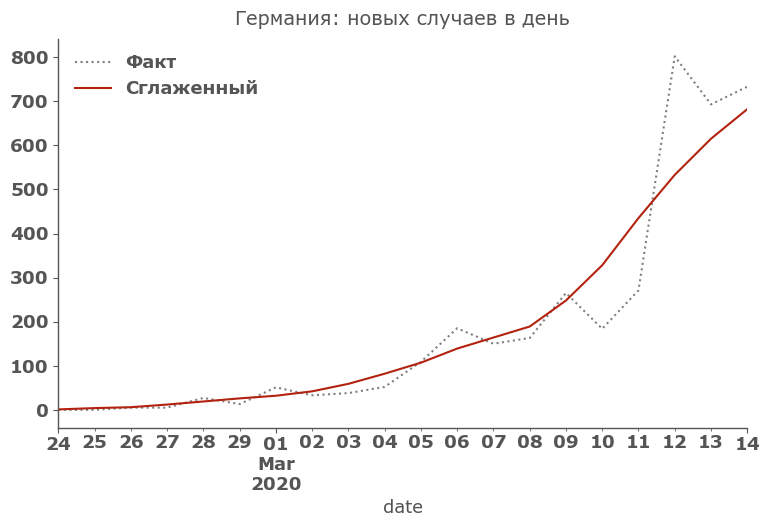

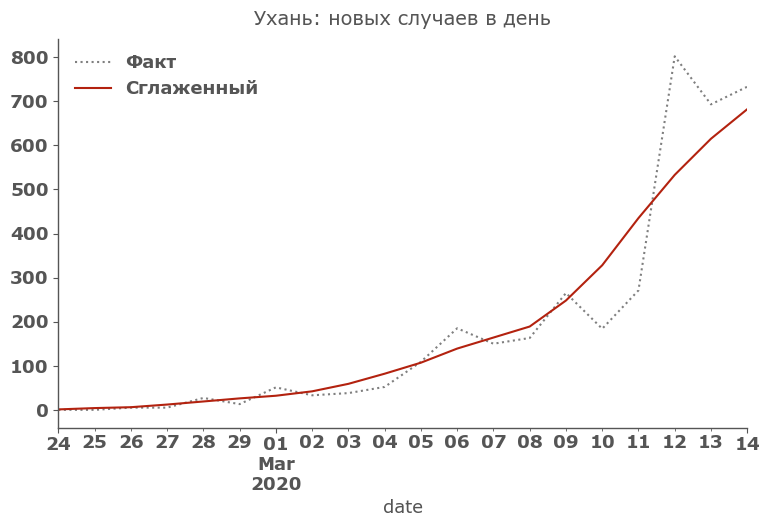

In [13]:
# Функция для подготовки данных по числу заболевших в день
def prepare_cases(cases):
    
    # Вычисление прироста числа заболевших в день
    new_cases = cases.diff()

    # Сглаживание данных с помощью скользящего окна (стандартное окно 7 дней)
    # Используется гауссово окно с стандартным отклонением 2 для лучшей интерпретации изменений 
    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    # Определение начальной даты для графика сглаженных данных
    # Если в данных есть недельный период с нулевым приростом, 
    # то сглаженные данные начинаются с конца этого периода
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

# Вывод графиков прироста числа заболевших для указанных стран
for state_name in ['Italy', 'Germany', 'Wuhan']:
    if state_name != 'Wuhan':
        # Извлечение данных по заданной стране из датафрейма
        cases = states.xs(state_name).rename(f"{state_name} cases")
    # Подготовка данных для построения графиков
    original, smoothed = prepare_cases(cases)

    # Построение графика
    original.plot(title=f"{translator.translate(state_name)}: новых случаев в день",
                   c='k',
                   linestyle=':',
                   alpha=.5,
                   label = 'Факт',
                   legend = True,
                 figsize=(640/72, 350/72))
    ax = smoothed.plot(label = 'Сглаженный', legend=True)
    plt.show()

Для расчета апостериорных распределений мы проводим следующие шаги:
1. Вычисляем $\lambda$ - ожидаемую скорость поступления для каждого дня пуассоновского процесса
2. Вычисляем распределение правдоподобности для каждого дня по всем возможным значениям $R_t$
3. Вычисляем матрицу процесса на основе значения $\sigma$, которое мы обсудили выше
4. Вычисляем наше начальное априорное распределение, потому что у нас нет предыдущего дня, от которого можно было бы взять апостериорное распределение
5. Запускаем цикл от дня 1 до конца, делая следующее:
   - Вычисляем априорное распределение, применяя гауссовское распределение к вчерашнему априорному распределению.
   - Применяем правило Байеса, умножая это априорное распределение на распределение правдоподобия, которое мы вычислили на шаге 2.
   - Делим на вероятность данных (также правило Байеса)

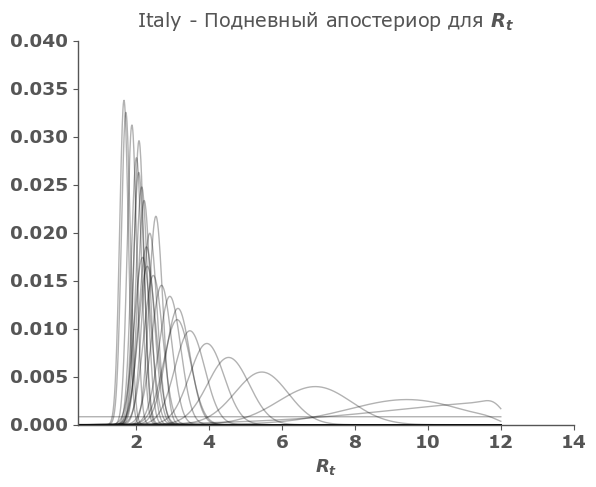

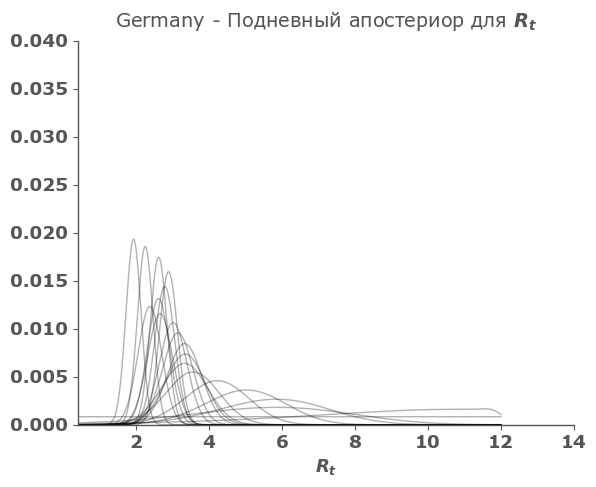

In [14]:
def get_posteriors(sr, sigma=0.15):
    # Вычисляем лямбду
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    # Расчитываем вероятность на каждый день
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    # Создаем Гауссову матрицу
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    # Нормализуем строки так, чтобы сумма была равна 1
    process_matrix /= process_matrix.sum(axis=0)
    # Расчитыаем начальный априор
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()
    # Создае мдатафрейм, в котором будут храниться наши апостериорные данные на каждый день.
    # Вставляем наш априор как первый апостериор.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    # Отслеживаем сумму логарифма вероятности данных для расчета максимального правдоподобия.
    log_likelihood = 0.0
    # Интервально применяем Байесовское правило
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):
        # Вычисляем новый априор
        current_prior = process_matrix @ posteriors[previous_day]
        # Вычисляем числитеьь P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        # Вычисляем знаминатель P(k)
        denominator = np.sum(numerator)
        # Выполняем полное правило Байеса
        posteriors[current_day] = numerator/denominator
        # Добавляем к текущей сумме логарифмических правдоподобий
        log_likelihood += np.log(denominator)
    return posteriors, log_likelihood
# Фиксируем значение сигмы только для примера

posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

for state_name in ['Italy', 'Germany']:
    cases = states.xs(state_name).rename(f"{state_name} случаев")
    original, smoothed = prepare_cases(cases)
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)
    ax = posteriors.plot(title=f'{state_name} - Подневный апостериор для $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,14),
           ylim=(0,0.04))

    ax.set_xlabel('$R_t$');

### Результат

Ниже вы можете увидеть каждый день (строку) одновременно визуализированной в виде постериорного распределения. Постериорные распределения начинаются с небольшой уверенности (широкие) и становятся все более уверенными (уже), что истинное значение $R_t$.

### Построение графика во временной области с доверительными интервалами

Так как наши результаты содержат неопределенность, мы хотели бы иметь возможность просматривать наиболее вероятное значение $R_t$ вместе с его интервалом наибольшей плотности.

In [15]:
hdis = highest_density_interval(posteriors, p=.9)
most_likely = posteriors.idxmax().rename('ML')
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-03-10,2.79,2.28,3.20
2020-03-11,2.89,2.44,3.27
2020-03-12,2.62,2.20,2.96
2020-03-13,2.25,1.87,2.58
2020-03-14,1.93,1.58,2.26


In [16]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE =  [1,0,0]
    MIDDLE = [1,1,1]
    BELOW =  [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Визуализация
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Эстетически экстраполируем достоверный интервал на 1 день в обе стороны
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Форматирование
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

### Выбор оптимального значения $\sigma$

В предыдущем разделе мы описали выбор оптимального значения $\sigma$, но мы просто предположили значение. Теперь, когда мы можем оценивать каждое состояние с помощью любого значения $\sigma$, у нас есть инструменты для выбора оптимального значения $\sigma$.

Ранее мы сказали, что выберем значение $\sigma$, которое максимизирует правдоподобие данных $P(k)$. Поскольку мы не хотим переобучать на любом одном состоянии, мы выбираем значение $\sigma$, которое максимизирует $P(k)$ для каждого состояния. Для этого мы складываем все логарифмы правдоподобия для каждого значения $\sigma$ для каждого состояния, а затем выбираем максимальное значение.

In [17]:
sigmas = np.linspace(1/20, 1, 20)
FILTERED_REGION_CODES = []
targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='state'):
    print(state_name)
    new, smoothed = prepare_cases(cases)#, cutoff=25)
    if len(smoothed) < 2: # == 0
        new, smoothed = prepare_cases(cases)#, cutoff=10)
    result = {}
    # Содержит все апостериорные значения для каждого заданного значения сигмы
    result['posteriors'] = []
    # Содержит логарифмическую вероятность по всем k для каждого значения сигмы
    result['log_likelihoods'] = []
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    # Сохраняем все результаты без имени состояния
    results[state_name] = result
    clear_output(wait=True)
print('Done.')

Done.


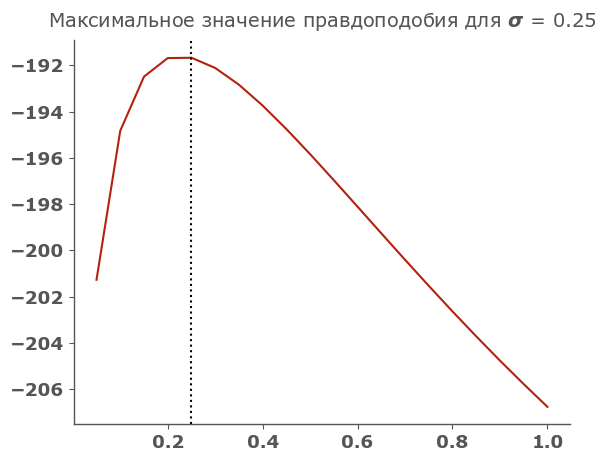

In [18]:
# Каждый индекс этого массива содержит общее количество логарифмических правдоподобий 
# для соответствующего индекса массива сигм.
total_log_likelihoods = np.zeros_like(sigmas)

# Прокручиваем результаты каждого состояния и добавляем логарифмические правдоподобия к промежуточной сумме.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Выбераем индекс с наибольшей логарифмической суммой правдоподобия.
max_likelihood_index = total_log_likelihoods.argmax()

# Выбериаем значение с наибольшей логарифмической вероятностью
sigma = sigmas[max_likelihood_index]

# Рисуем график
fig, ax = plt.subplots()
ax.set_title(f"Максимальное значение правдоподобия для $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [19]:
final_results = None 

# Создаем пустой словарь для сохранения результатов
save = {}

# Проходимся циклом по каждому штату и его результатам
for state_name, result in results.items():
    
    # Выводим название текущего штата
    print(state_name)
    
    # Получаем значения постериорных распределений для текущего штата
    posteriors = result['posteriors'][max_likelihood_index]
    
    # Получаем 90%-й и 50%-й HDI для текущего штата
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    
    # Получаем наиболее вероятное значение для текущего штата
    most_likely = posteriors.idxmax().rename('ML')
    
    # Объединяем полученные значения в таблицу
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    
    # Сохраняем таблицу в словарь
    save[state_name] = result
    
    # Объединяем таблицу с результатами всех штатов
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    
    # Очищаем вывод консоли
    clear_output(wait=True)

# Выводим сообщение о завершении работы
print('Done.')

# Группируем результаты по штатам
final_results.groupby('state')

Done.


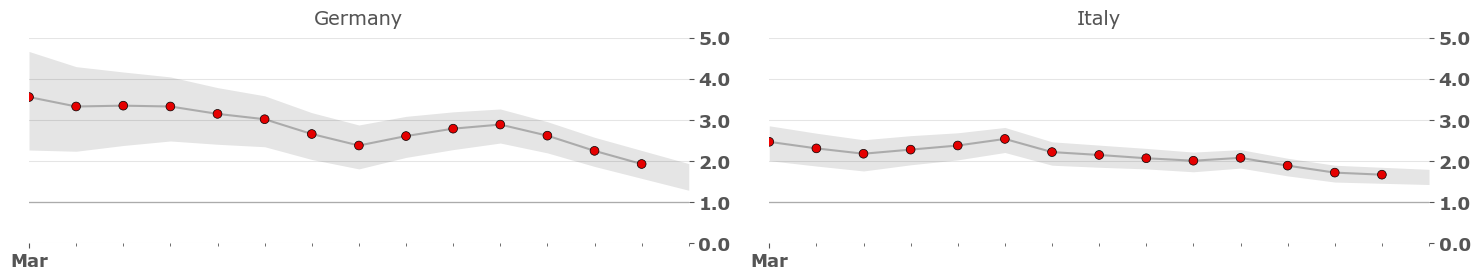

In [20]:
# Определяем количество столбцов и строк для графиков
ncols, nrows = 2, 1

# Создаем объект рисунка и массив объектов осей 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

# Организуем цикл по группам результатов, сгруппированным по штатам
for i, (state_name, result) in enumerate(final_results.groupby('state')):
    
    # Проверяем, достаточно ли данных для построения графика
    if len(result) < 2:
        print(f"Not enough data to plot: {state_name}")
        continue
    
    # Вызываем функцию plot_rt, которая рисует график для каждого штата
    # и передаем ей данные для построения графика, объект осей, на котором нужно построить график,
    # и имя штата для его отображения на графике
    plot_rt(result, axes.flat[i], state_name)

# Устанавливаем отступы между подграфиками так, чтобы заголовки не перекрывались 
fig.tight_layout()

# Устанавливаем цвет фона рисунка 
fig.set_facecolor('w')

In [21]:
final_results = final_results.groupby('state').apply(lambda x: x.iloc[1:].droplevel(0))

In [22]:
no_lockdown = [
    'Italy', 'IT',
    'Germany', 'DE'
]
lockdown = [ 'Wuhan', 'CH' ]
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
ERROR_BAR_COLOR = [.3,.3,.3]
states = pd.concat([states,wuhan], keys = ['states', 'wuhan'])

In [23]:
#states.info()

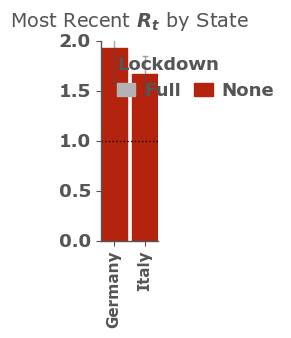

In [24]:
# Отфильтровать регионы, которые нужно исключить
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGION_CODES)

# Сгруппировать данные по регионам и выбрать последние значения
mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

# Функция для построения графика с результатами 
# и разделением регионов на те, где есть полная или 
# частичная карантинная мера и те, где ее нет
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs() # Вычисляем ошибку
    bars = ax.bar(mr.index, # Рисуем столбцы
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown: # Делаем одну группу регионов
            bar.set_color(NONE_COLOR)
        if state_name in lockdown: # Делаем другую группу регионов
            bar.set_color(FULL_COLOR)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11) # Меняем подписи по оси X
    ax.margins(0)
    ax.set_ylim(0,2.) # Устанавливаем границы по оси Y
    ax.axhline(1.0, linestyle=':', color='k', lw=1) # Добавляем горизонтальную линию на графике

    # Создаем легенду отображения значения полной и частичной карантинной меры
    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left" # Задаем выравнивание легенды
    fig.set_facecolor('w')
    return fig, ax

#mr.sort_values('ML', inplace=True)
plot_standings(mr);
# С Уханью возникла проблема при обработке данных, на график не попала

# Альтернативный метод расчёта

In [25]:
df = pd.read_csv('owid-covid-data.csv', parse_dates=['date']) # Data Frame Europe

In [26]:
# Гамма распределение

# Расчёт дискретного распределения
def dis_gamma(a: float, scale: float, loc: float = 0) -> np.ndarray:
    return dis_distr(gamma(a=a, scale=scale, loc=loc))

def dis_distr(distrb: rv_continuous) -> np.ndarray:
    upper_lim = np.ceil(distrb.ppf(1 - 1e-6))
    bin_lims = np.linspace(0.5, upper_lim + 0.5, int(upper_lim + 1))
    cdf = distrb.cdf(bin_lims)
    pmf = np.diff(cdf, prepend=0)
    return pmf / pmf.sum()

# Распределение генерационных интервалов
def standard_si_distr():
    return dis_gamma(2.6, scale = 0.4) # Подставляем значения из презентации

# Распределение инкубационных периодов
def standard_incubation_time_distr():
    return dis_gamma(1.352, scale = 0.265) # Подставляем значения из презентации

# Негативное биномиальное распределение
def onset_to_reporting_distr_brauner():
    mu, alpha = 5.25, 1.57
    distrb = nbinom(n = 1 / alpha, p = 1 - alpha * mu / (1 + alpha * mu))
    x = range(int(distrb.ppf(1 - 1e-6)))
    return distrb.pmf(x)

# Распределение задержек
def standard_infection_to_reporting_distr():
    return np.convolve(standard_incubation_time_distr(), 
                       onset_to_reporting_distr_brauner())

# Получаем наши распределения
si_distrb = standard_si_distr()
delay_distrb = standard_infection_to_reporting_distr()

# Определяем начальную дату надежной R-оценки
def start_date(
        confirmed_cases: pd.Series, 
        gt_distribution: np.ndarray, 
        r_window_size: Optional[int] = None, 
) -> date:
    # Вычисляем кумулятивное количество случаев заболевания
    cumulative_cases = confirmed_cases.cumsum()
    # Находим дату, когда количество случаев заболевания стало больше или равно 12
    over_dozen_cases_date = cumulative_cases.ge(12).idxmax()
    # Находим дату первого подтвержденного случая
    index_case_date = confirmed_cases.ne(0).idxmax()
    # Находим среднее время поколения инфекции
    mean_gt = gt_distribution @ np.arange(len(gt_distribution)) / gt_distribution.sum()
    # Если значение r_window_size не передано, то устанавливаем его равным 0
    r_window_size = r_window_size if isinstance(r_window_size, int) else 0
    # Определяем дату, когда будет достигнуто первое из условий
    # - кумулятивное количество случаев заболевания стало больше или равно 12,
    # - дата первого подтвержденного случая плюс среднее время поколения инфекции,
    # - дата первого подтвержденного случая плюс размер окна для вычисления R0 (если он передан)
    condition1_date = over_dozen_cases_date
    condition2_date = index_case_date + timedelta(days=np.ceil(mean_gt))
    condition3_date = index_case_date + timedelta(days=r_window_size)
    # Находим первую дату, которая удовлетворяет любому из условий
    first_true_date = max(condition1_date, condition2_date, condition3_date)
    return first_true_date

В качестве входных параметров принимаем временной ряд confirmed_cases - последовательность подтвержденных случаев заболевания, 
delay_distribution - распределение задержки подтверждения случаев.

In [27]:
# Функция вычисляет среднюю задержку подтверждения случаев и определяет конечную дату

# Определяем конечную дату
def end_date(confirmed_cases: pd.Series, delay_distribution: np.ndarray) -> date:
    # Находим среднюю задержку подтверждения случаев
    delay_mean = delay_distribution.dot(np.arange(len(delay_distribution)))
    # Находим конечную дату
    return confirmed_cases.index[-1] - timedelta(days=int(delay_mean))

In [28]:
# Вспомогательные функции:

# Разыгрываем временной ряд той же длины, что и исходный
def bootstrap_series(ser: pd.Series) -> pd.Series:
    resampled = np.random.multinomial(ser.sum(), ser / ser.sum())
    return pd.Series(resampled, index=ser.index)

# Нормировка ряда (учитываем длины)
def renormalise_series(ser: pd.Series, reference_ser: pd.Series) -> pd.Series:
    assert len(ser.index) == len(reference_ser.index), \
        'length of series to be renormalised does not match length of reference series'
    ser[ser < 0] = 0
    norm_ser = ser.sum()
    norm_ref_ser = reference_ser.sum()
    ser = ser * norm_ref_ser / norm_ser
    return ser

# Сглаживание ряда
def smooth_series(ser: pd.Series, window_width: int) -> pd.Series:
    if window_width != 1:
        if window_width % 7 != 0:
            warnings.warn('window_width is recommended to be a multiple of 7 to account for weekly patterns.')
    endog = ser.values
    exog = np.array(range(len(ser)))
    frac = window_width / len(exog)
    smooth = lowess(endog = endog, exog = exog, frac = frac, it = 0, delta = 0.0, 
                    is_sorted = True, missing = 'raise', return_sorted = False)
    smooth_ser = pd.Series(smooth, index=ser.index)
    smooth_ser = renormalise_series(smooth_ser, ser)
    return smooth_ser

Сдвиг ряда зарегистрированных случаев (смотрим в прошлое)
𝑃(𝑘) ≡ delay_distrb[k] = вероятность того, что человек заболел k дней назад

In [29]:
def shift_and_pad(ser: pd.Series, delay_distrb: np.ndarray) -> pd.Series:
    assert not (delay_distrb == 0).any(), 'Delay distribution array must contain only nonzero values'
    # Человек заболевает раньше, чем это обнаруживается, поэтому смещаемся в прошлое
    k = len(delay_distrb)  # Количество дней с момента заражения до учёта в статистике
    ix_start_new = ser.index[0] - timedelta(days = k - 1)
    ix_end = ser.index[-1]
    new_ix = pd.date_range(start = ix_start_new, end = ix_end, freq = 'D')
    ser_extended = ser.reindex(new_ix, method = 'bfill')
    # Сдвиг временных рядов
    mode_delay = delay_distrb.argmax()
    ser_shifted = ser_extended.shift(-mode_delay).ffill()
    ser_shifted[ser_shifted <= 0] = 1 # Меняем отрицательные значения на 1
    return ser_shifted

Получаем инфекции с максимальной вероятностью. Имеем зарегистрированные случаи (ser) и задержки от заражения до репортации (delay_distrib)

In [30]:
# Функция Likelihood
def deconvolve_series(ser: pd.Series, delay_distrb: np.ndarray) -> pd.Series:
    assert abs(delay_distrb.sum() - 1.0) < 0.001, "Delay distribution must sum to 1"
    assert all(ser >= 0)
    ser = ser[ser.ne(0).idxmax():]
    # Получаем начальное значение
    ser_deconvolved = shift_and_pad(ser, delay_distrb)
    k = len(delay_distrb)  # количество дней с момента заражения до репортации
    n = len(ser_deconvolved)
    # Ядро задержки
    delay_distrb_rev = np.flip(delay_distrb)
    col = np.concatenate(([delay_distrb_rev[0]], np.zeros(n - k)), axis=None)
    row = np.concatenate((delay_distrb_rev, np.zeros(n - k)), axis=None)
    delay_kernel = np.concatenate((np.zeros((k - 1, n)), la.toeplitz(col, row)), axis=0)
    # Смотрим все дни, q_j - вероятность, что о заражении в день j сообщат между днями k и n
    q = pd.Series(np.sum(delay_kernel, axis = 0), index=ser_deconvolved.index) 
    # Обратная свертка
    for _ in range(100):
        exp_obs_array = delay_kernel.dot(ser_deconvolved)
        expected_observed = pd.Series(exp_obs_array[(k):], index=ser.index)
        mD_overE = delay_kernel[(k):, :] * (ser / expected_observed).values.reshape(-1, 1)
        ser_deconvolved = (ser_deconvolved / q) * np.sum(mD_overE, axis=0)
        assert not ser_deconvolved.isna().any(), f'deconvolution has nan in iteration {_}'
        EminusDsq_overE = np.square(expected_observed - ser)
        chi_sq = (EminusDsq_overE / expected_observed).sum() / (n - k + 1)
        if chi_sq < 1:
            break
    return ser_deconvolved

In [31]:
# Общая зараженность
def overall_infectivity(infections_ts: pd.Series, gt_distribution: np.array) -> pd.Series:
    padded_incidence = np.pad(
        infections_ts.values, 
        (len(gt_distribution) - 1, 0), 
        mode='constant', constant_values=0
    )
    infectivity_array = np.convolve(
        padded_incidence, 
        gt_distribution, 
        mode="valid"
    )
    return pd.Series(infectivity_array, index=infections_ts.index)

In [32]:
# Оценка репродуктивных чисел
def estimate_r(
        infections_ts: pd.Series, #заражения
        gt_distribution: np.ndarray, #генерационные интервалы
        a_prior: float, #shape априорного гамма
        b_prior: float, #scale априорного гамма
        window_size: Optional[int] = None, #размер окна
        boundary_dates: Optional[List[date]] = None #границы
) -> pd.DataFrame:
    assert abs(gt_distribution.sum() - 1.0) < 0.001, "Serial interval distribution must sum to 1"
    assert (infections_ts >= 0).all(), "Infection numbers cannot be negative"
    if window_size is None and boundary_dates is None:
        raise ValueError("Either window_size or change_dates must be set")
    infectivity_ts = overall_infectivity(
        infections_ts=infections_ts, 
        gt_distribution=np.asarray(gt_distribution)
    )
    df = pd.DataFrame(
        {'infections': infections_ts, 'infectivity': infectivity_ts}
    )
    sums = sum_by_split_dates(df, boundary_dates) if boundary_dates is not None else df.rolling(window_size).sum().dropna()
    return pd.DataFrame({
        'a_posterior': a_prior + sums.infections, 
        'b_posterior': 1 / (1 / b_prior + sums.infectivity)
    }) #датафрейм с апостериорными значениями shape и scale гамма распределения

In [33]:
def sum_by_split_dates(df: pd.DataFrame, split_dates: List[date]):
    idx = pd.cut(df.index, bins=np.array(split_dates, dtype=np.dtype('datetime64')), include_lowest=True, right=False)
    sums = df.groupby(idx).sum()
    return pd.DataFrame({'interval': idx}, index=df.index).join(sums, on='interval').drop('interval', axis=1).dropna()

In [34]:
def gamma_quantiles(q: float, a: np.ndarray, b: np.ndarray):
    return gammaincinv(a, q) * b

In [35]:
# Основная функция для оценки воспроизводящего числа (R) на основе наблюдаемых случаев инфекции

def sample_r(
        confirmed_cases: pd.Series,  # временной ряд подтвержденных случаев инфекции
        gt_distribution: np.ndarray,  # распределение времени повторной генерации инфекции
        delay_distribution: np.ndarray,  # распределение задержки между датой заражения и датой подтверждения случая 
        a_prior: float,  # априорный параметр a для вычисления апостериорного распределения гиперпараметра 
        b_prior: float,  # априорный параметр b для вычисления апостериорного распределения гиперпараметра 
        smoothing_window: int,  # окно для сглаживания путем скользящего среднего
        r_window_size: Optional[int] = None, # окно для оценки среднего R, если не указано, оценивается для всех точек
        r_interval_dates: Optional[List[date]] = None, # интервал дат, для которых требуется оценить R, если не указано, оценивается для всех дат 
) -> pd.DataFrame:
    bs_confirmed_cases = bootstrap_series(confirmed_cases)  # Бутстреп временного ряда
    sm_bs_confirmed_cases = smooth_series(bs_confirmed_cases, smoothing_window)  # сгладить временной ряд с помощью скользящего среднего 
    max_likelihood_infections = deconvolve_series(sm_bs_confirmed_cases, delay_distribution) # Оценить реальное количество случаев инфекции
    posterior_reproduction_number = estimate_r(
        infections_ts=max_likelihood_infections, # наблюдаемые случаи инфекции
        gt_distribution=gt_distribution, # распределение времени повторной генерации
        a_prior=a_prior, # априорный параметр a
        b_prior=b_prior, # априорный параметр b
        window_size=r_window_size, # окно для оценки среднего R
        boundary_dates=r_interval_dates  # интервал дат, для которых требуется оценить R
    )
    assert len(posterior_reproduction_number) > 0  # Проверка на случай отсутствия данных
    return posterior_reproduction_number

In [36]:
# Медианные квантили выборок
def aggregate_quantiles_r(bag: List[pd.DataFrame], quantiles: Iterable[float]) -> pd.DataFrame:
    all_samples = pd.concat([r_sample for r_sample in bag], axis=0)
    all_samples['R_mean'] = all_samples.a_posterior * all_samples.b_posterior
    all_samples['R_var'] = all_samples.a_posterior * all_samples.b_posterior ** 2
    for q in quantiles:
        all_samples[f'Q{q}'] = gamma_quantiles(q, all_samples.a_posterior, all_samples.b_posterior)
    aggregate_quantiles = all_samples.drop(['a_posterior', 'b_posterior'], axis = 1).groupby(all_samples.index).median()
    return aggregate_quantiles

In [37]:
# Агрегированная бутстрапированная выборка (получаем агрегированные квантили)

def bagging_r(
        confirmed_cases: pd.Series,  # Подтвержденные случаи COVID-19 (временной ряд)
        gt_distribution: np.ndarray,  # Нулевое распределение генерации случаев (Random Generation Interval distribution)
        delay_distribution: np.ndarray,  # Распределение задержки отчета случаев (Reporting Delay distribution)
        a_prior: float,  # априорная альфа
        b_prior: float,  # априорная бета
        smoothing_window: int,  # Ширина скользящего окна для сглаживания
        r_window_size: Optional[int] = None,  # Размер окна, чтобы сгенерировать варианты R
        r_interval_dates: Optional[List[date]] = None,  # Левые границы интервалов, в которых оцениваются R
        n_samples: int = 100,  # Число образцов бутстрапа для оценки
        quantiles: Iterable[float] = (0.025, 0.5, 0.975),  
        auto_cutoff: bool = True  # Предотвращает вывод вне граней карантина 
) -> pd.DataFrame:
    assert not any(q >= 1 or q <= 0 for q in quantiles), 'квантили должны быть между 0 и 1' 
    assert isinstance(confirmed_cases, pd.Series), 'подтвержденные случаи должны быть типа pandas.Series' 
    confirmed_cases = confirmed_cases.astype(int)  # Приведение типа подтвержденных случаев к целочисленному формату
    if r_interval_dates is not None:  
        r_interval_dates = sorted(r_interval_dates, reverse=False)  

    # Автоматически определить даты начала и конца карантина, если они не заданы
    if auto_cutoff:
        start_cutoff_date = start_date(
            confirmed_cases=confirmed_cases,  # Подтвержденные случаи COVID-19 (временной ряд)
            gt_distribution=gt_distribution,  # Нулевое распределение генерации случаев 
            r_window_size=r_window_size  # Размер окна, чтобы сгенерировать варианты R
        )
        end_cutoff_date = end_date(
            confirmed_cases=confirmed_cases,  # Подтвержденные случаи COVID-19 (временной ряд)
            delay_distribution=delay_distribution  # Распределение задержки отчета случаев (Reporting Delay distribution)
        )
        if r_interval_dates is not None: 
            if r_interval_dates[0] < start_cutoff_date: 
                # Меняем границы первого интервала
                r_interval_dates = [start_cutoff_date] + [d for d in r_interval_dates if d > start_cutoff_date]  
                warnings.warn(
                    f'Первая граница интервала установлена на {str(start_cutoff_date)}. '
                    'Если вы не хотите этого, установите auto_cutoff=False.'
                )
            if r_interval_dates[-1] > end_cutoff_date: 
                # Меняем границы последнего интервала
                r_interval_dates = [d for d in r_interval_dates if d < end_cutoff_date] + [end_cutoff_date]  
                warnings.warn(
                    f'Последняя граница интервала установлена на {str(end_cutoff_date)}. '
                    'Если вы не хотите этого, установите auto_cutoff=False.'
                )

    if r_interval_dates is not None:  # Если интервалы наблюдений R заданы
        assert len(r_interval_dates) > 1, 'Интервалы наблюдения должны быть больше одного.'

    bag = []
    for _ in range(n_samples):
        # Генерируем одно значение R с помощью алгоритма Метрополиса-Гастингса
        posterior_r = sample_r(
            confirmed_cases=confirmed_cases,
            gt_distribution=gt_distribution,
            delay_distribution=delay_distribution,
            a_prior=a_prior,
            b_prior=b_prior,
            smoothing_window=smoothing_window,
            r_window_size=r_window_size,
            r_interval_dates=r_interval_dates
        )
        bag.append(posterior_r)  # Добавляем полученный результат в список результатов
    # Получаем агрегированные квантили
    r_output = aggregate_quantiles_r(bag, quantiles) 
    # Приcоединяем целочисленное значение квантиля к значениям подтвержденных случаев COVID-19
    r_output = pd.concat((confirmed_cases.rename('cases'), r_output), axis=1)  
    if auto_cutoff:
        # Предотвращаем печать значений вне границ карантина
        r_output = r_output[(start_cutoff_date <= r_output.index) & (r_output.index <= end_cutoff_date)]  
    return r_output  # Возвращаем рассчитанные значения R и подтвердженных случаев COVID-19

Агрегированная бутстрапированная выборка, получаем агрегированные квантили с дефолтными параметрами. На основе них будем рисовать

In [38]:
def r_covid(
    confirmed_cases: pd.Series, 
    # Распределение заболеваемости/восстановления
    gt_distribution: np.array = standard_si_distr(),  
    # Распределение задержек между заболеванием и подтверждением диагноза
    delay_distribution: np.array = standard_infection_to_reporting_distr(),  
    a_prior: float = 3,  # Параметр распределения Априори
    b_prior: float = 1,  # Параметр распределения Априори
    smoothing_window: int = 21,  # Размер окна для сглаживания
    r_window_size: Optional[int] = 3,  # Длина окна для подсчёта коэффициента R
    r_interval_dates: Optional[List[date]] = None,  # Интервал времени (список дат) для подсчёта коэффициента R
    n_samples: int = 100,  # Количество семплов для бэггинга
    quantiles: Iterable[float] = (0.025, 0.5, 0.975),  # Квантили для оценки доверительного интервала
    auto_cutoff: bool = True  # Автоматический подбор границ заражения
) -> pd.DataFrame:
    return bagging_r(
        confirmed_cases, 
        gt_distribution = gt_distribution, 
        delay_distribution = delay_distribution, 
        a_prior = a_prior, 
        b_prior = b_prior, 
        smoothing_window = smoothing_window, 
        r_window_size = r_window_size, 
        r_interval_dates = r_interval_dates, 
        n_samples = n_samples, 
        quantiles = quantiles, 
        auto_cutoff = auto_cutoff
    )

# Германия

In [39]:
# Из данных выделяем 3 поля: location, date, new_cases
country = 'Germany'
my_cases = pd.DataFrame()
my_cases['Date'] = df['date']
my_cases['Cases'] = df['new_cases']
my_cases['Location'] = df['location']
my_cases = my_cases.loc[(my_cases['Location'] == country)]
my_cases = my_cases.drop(columns='Location')
my_cases = my_cases.dropna()
my_cases['Cases'] = my_cases['Cases'].astype(int)
my_cases = my_cases.set_index('Date')['Cases']

In [40]:
ch_time_varying_r = r_covid(my_cases)
ch_time_varying_r.head(1)

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-02-03,2.0,1.357762,0.345978,0.489134,1.282726,2.733787


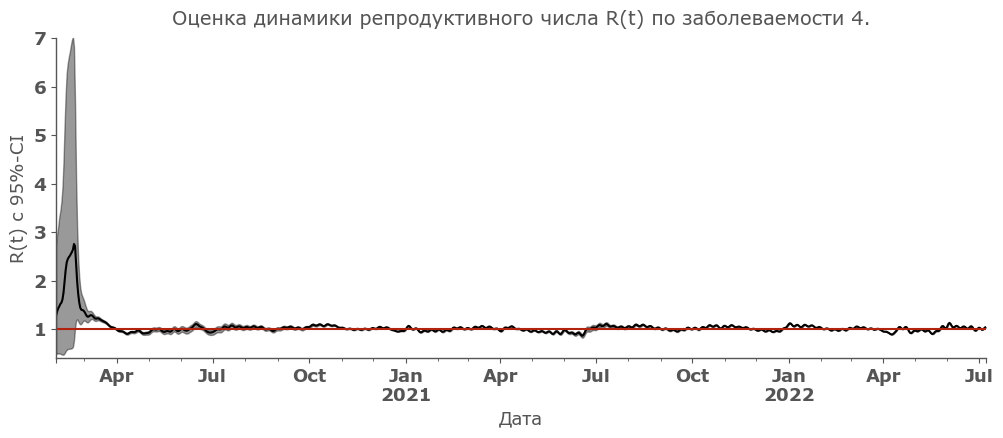

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ch_time_varying_r.loc[:, 'Q0.5'].plot(ax=ax, color='Black') # Associated Color of Germany
ax.fill_between(ch_time_varying_r.index, 
                    ch_time_varying_r['Q0.025'], 
                    ch_time_varying_r['Q0.975'], 
                    color='black', alpha=0.4)
ax.set_xlabel('Дата')
ax.set_ylabel('R(t) c 95%-CI')
ax.set_ylim([0.4, 7])
ax.axhline(y = 1)
ax.set_title('Оценка динамики репродуктивного числа R(t) по заболеваемости ' + translator.translate('in '+country))
plt.show();

# Италия

In [42]:
country = 'Italy'
my_cases = pd.DataFrame()
my_cases['Date'] = df['date']
my_cases['Cases'] = df['new_cases']
my_cases['Location'] = df['location']
my_cases = my_cases.loc[(my_cases['Location'] == country)]
my_cases = my_cases.drop(columns='Location')
my_cases = my_cases.dropna()
my_cases['Cases'] = my_cases['Cases'].astype(int)
my_cases = my_cases.set_index('Date')['Cases']

Смотрим среднее, дисперсию, квантили

In [43]:
ch_time_varying_r = r_covid(my_cases)

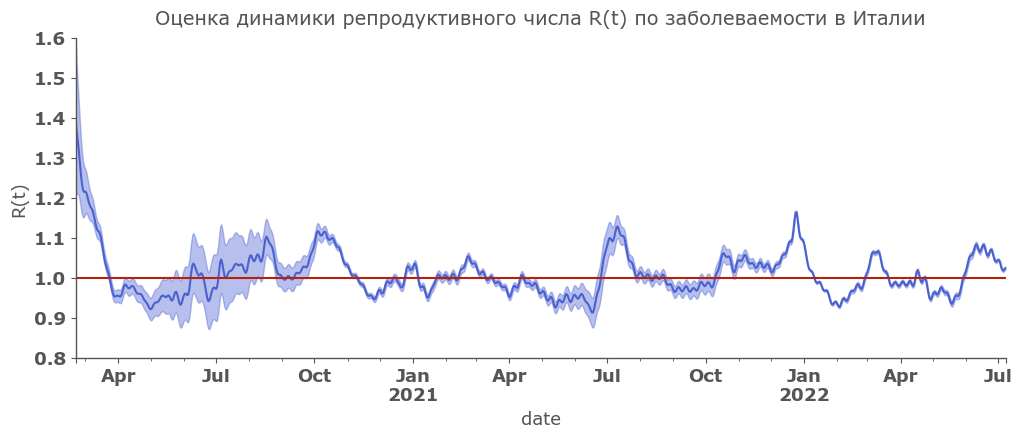

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# Savoy Blue - Associated Color of Italy
savoyblue = matplotlib.colors.hex2color('#4B61D1')
ch_time_varying_r.loc[:, 'Q0.5'].plot(ax=ax, color = savoyblue)
ax.fill_between(ch_time_varying_r.index, ch_time_varying_r['Q0.025'], ch_time_varying_r['Q0.975'], 
                color = savoyblue, alpha=0.4)
ax.set_xlabel('date')
ax.set_title('Оценка динамики репродуктивного числа R(t) по заболеваемости ' + translator.translate('in '+country))
ax.set_ylabel('R(t)')
ax.set_ylim([0.8, 1.6])
ax.axhline(y = 1)
plt.show();

# Задание 2

In [45]:
# Аппроксимация прямой
def fit_line(points):
    r = np.polyfit([p[0] for p in points], [p[1] for p in points], 1)
    print(f'y = {r[0]:.2f}x + {r[1]:.2f}')
    return r[0], r[1]

fit_line(np.random.rand(21, 2))
fit_line(np.array([[0, 3], [1, 4], [2, 5], [3, 6]]))

y = -0.19x + 0.61
y = 1.00x + 3.00


(0.9999999999999994, 3.0000000000000018)

In [46]:
x = np.linspace(-100., 100.)

In [47]:
def getr0(a):
    G, k = 6.5, 16.25
    ro = G * a
    return (1 + k * ro) ** (1 / k)

# Германия

In [48]:
location = 'Germany'
my_cases = pd.DataFrame()
my_cases['Date'] = df['date']
my_cases['Cases'] = df['new_cases']
my_cases['Location'] = df['location']
my_cases = my_cases.loc[(my_cases['Location'] == location)]
my_cases = my_cases.loc[(my_cases['Date'] < '2020-03-15')]
my_cases = my_cases.drop(columns='Location')
my_cases = my_cases.dropna()
my_cases['Cases'] = my_cases['Cases'].astype(int)
my_cases = my_cases.set_index('Date')['Cases']

In [49]:
res = my_cases.to_numpy()
vals = []
for i in range(len(res)):
    vals.append([i, res[i]])
vals =np.array(vals)

y = 0.40x + -3.54


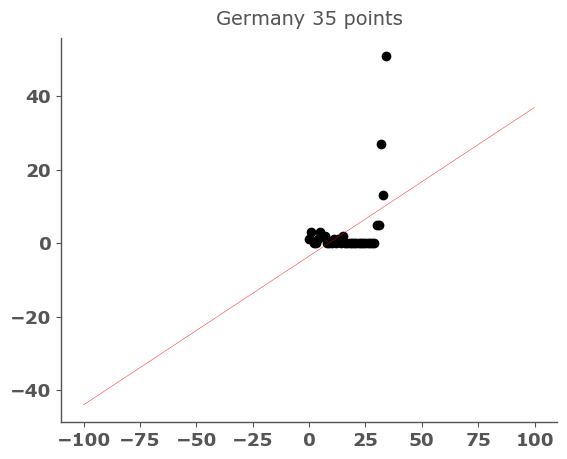

R0: 1.262
y = 1.66x + -18.94


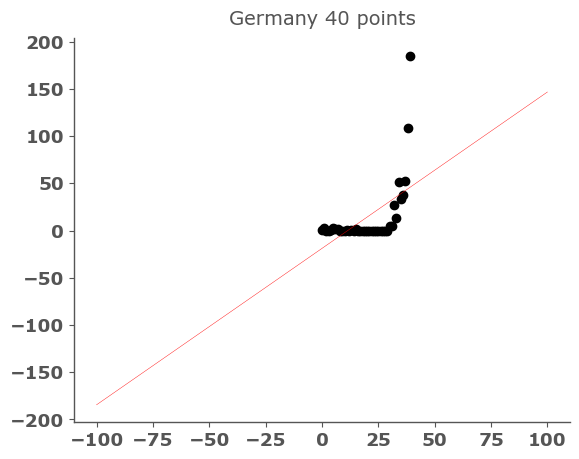

R0: 1.375
y = 8.26x + -115.13


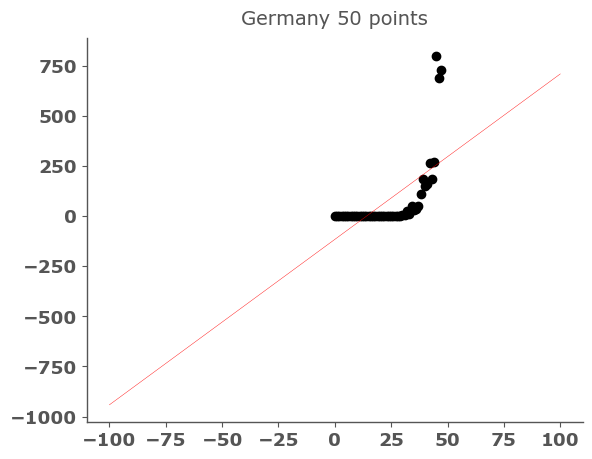

R0: 1.517
y = 8.26x + -115.13


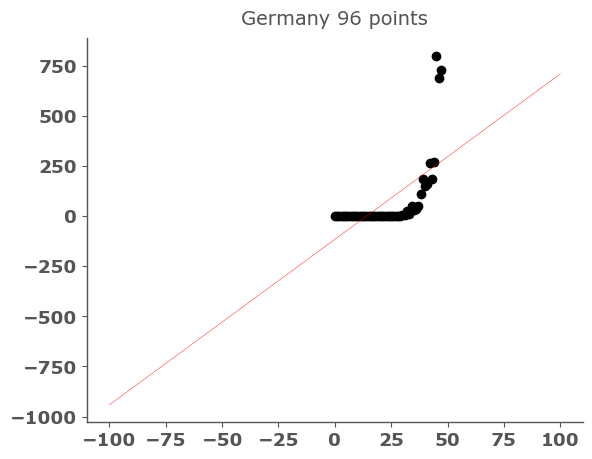

R0: 1.517


In [50]:
germanyr = []
for cut in [35, 40, 50, vals.size]:
    tmp = vals[:cut]
    a, b = fit_line(tmp)
    plt.plot(x, a * x + b,  c ='red', linewidth = 0.3)
    plt.title(location + ' ' + str(cut) + ' points')
    plt.scatter(tmp[:, 0], tmp[:, 1],  c ='black')
    plt.show()
    germanyr.append(getr0(a))
    print(f"R0: {getr0(a):0,.3f}")

# Италия

In [51]:
location = 'Italy'
my_cases = pd.DataFrame()
my_cases['Date'] = df['date']
my_cases['Cases'] = df['new_cases']
my_cases['Location'] = df['location']
my_cases = my_cases.loc[(my_cases['Location'] == location)]
my_cases = my_cases.loc[(my_cases['Date'] < '2020-03-15')]
my_cases = my_cases.drop(columns='Location')
my_cases = my_cases.dropna()
my_cases['Cases'] = my_cases['Cases'].astype(int)
my_cases = my_cases.set_index('Date')['Cases']

In [52]:
res = my_cases.to_numpy()
vals = []
for i in range(len(res)):
    vals.append([i, res[i]])
vals = np.array(vals)

y = 0.60x + -3.89


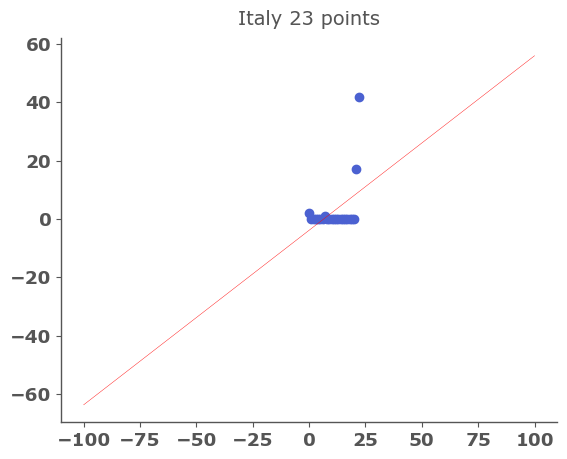

R0: 1.292
y = 6.01x + -49.60


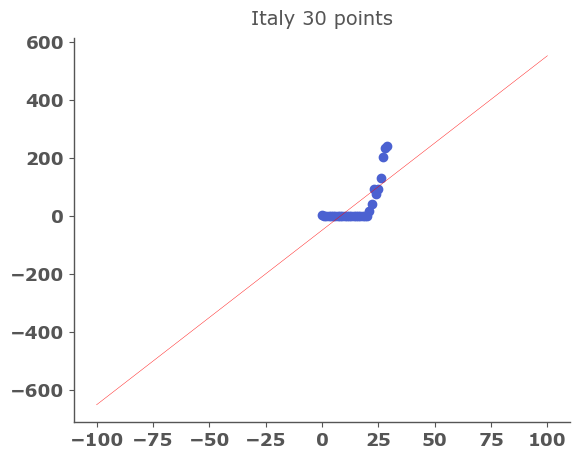

R0: 1.488
y = 14.65x + -138.80


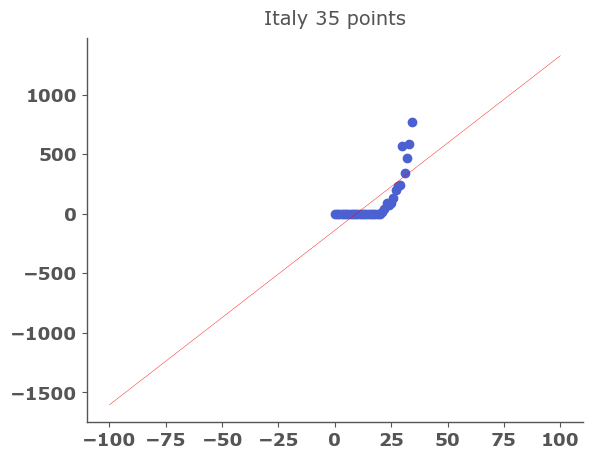

R0: 1.571
y = 28.84x + -308.56


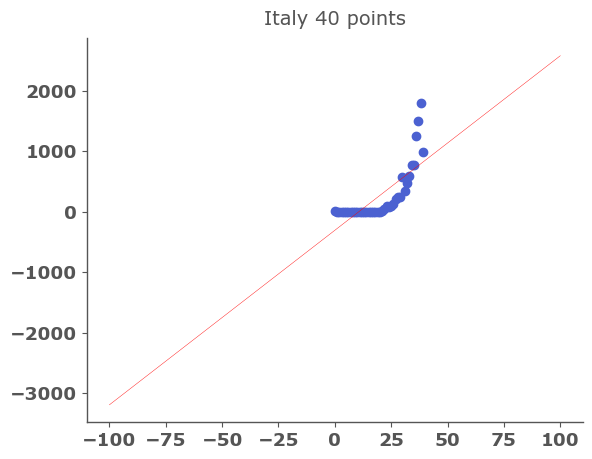

R0: 1.638
y = 50.07x + -595.76


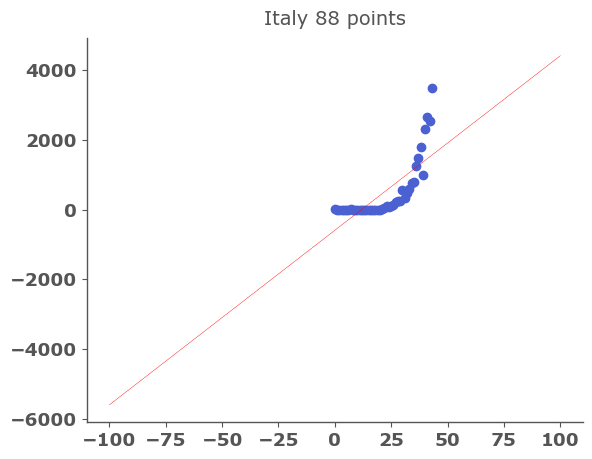

R0: 1.695


In [53]:
italyr = []
for cut in [23, 30, 35, 40, vals.size]:
    tmp = vals[:cut]
    a, b = fit_line(tmp)
    plt.plot(x, a * x + b,  c ='red', linewidth = 0.3)
    plt.title(location + ' ' + str(cut) + ' points')
    plt.scatter(tmp[:, 0], tmp[:, 1],  c = savoyblue)
    plt.show()
    italyr.append(getr0(a))
    print(f"R0: {getr0(a):0,.3f}")

# Ухань

In [54]:
dfw = pd.read_csv('Wuhan-full.csv', parse_dates=['date']) # Data Frame Wuhan

In [55]:
my_cases = pd.DataFrame()
my_cases['Date'] = dfw['date']
my_cases['Cases'] = dfw['cases']
my_cases = my_cases.loc[(my_cases['Date'] < '2020-02-20')]
my_cases = my_cases.dropna()
my_cases['Cases'] = my_cases['Cases'].astype(int)
my_cases = my_cases.set_index('Date')['Cases']

In [56]:
location = 'Wuhan'
res = my_cases.to_numpy()
vals = []
for i in range(len(res)):
    vals.append([i, res[i]])
vals = np.array(vals)

y = 231.60x + 331.40


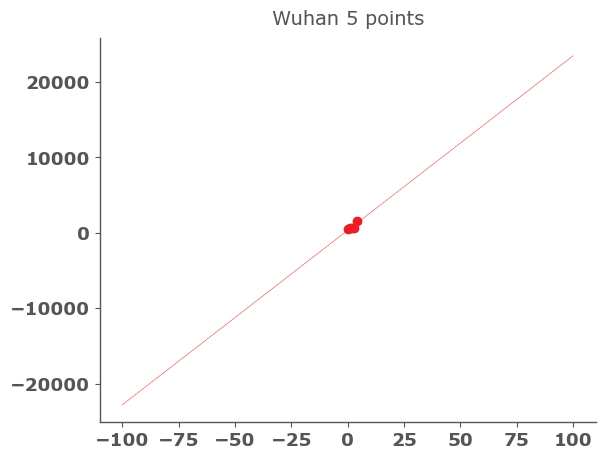

R0: 1.862
y = 400.82x + 6.49


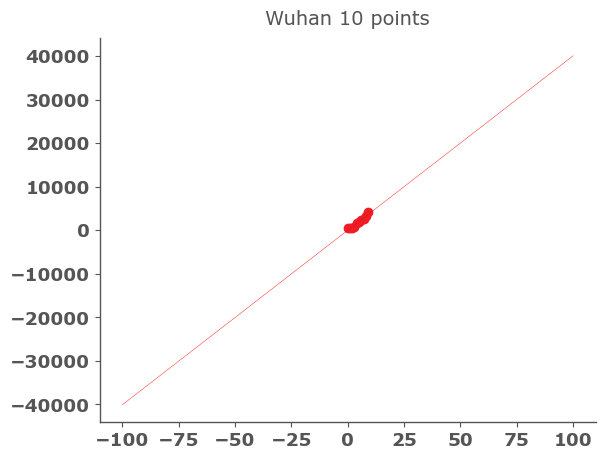

R0: 1.926
y = 759.14x + -1333.02


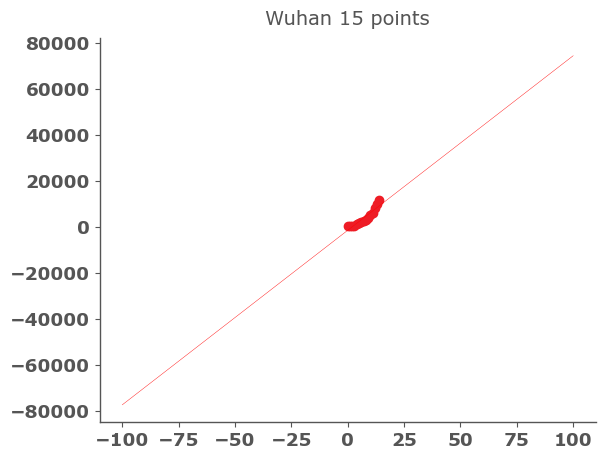

R0: 2.004
y = 1832.38x + -8343.51


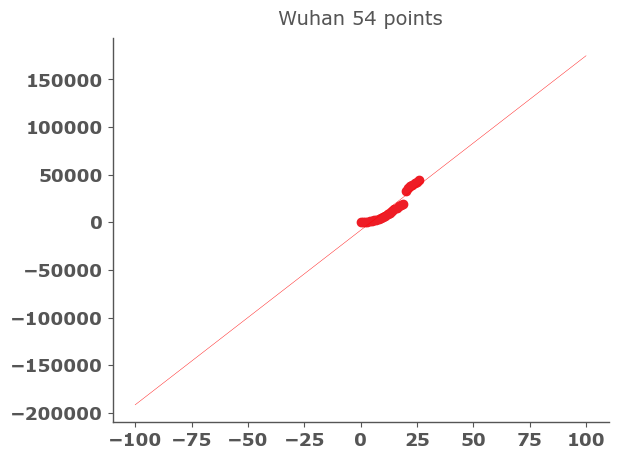

R0: 2.115


In [57]:
wuhanr = []
for cut in [5, 10, 15, vals.size]:
    tmp = vals[:cut]
    a, b = fit_line(tmp)
    plt.plot(x, a * x + b, c ='red', linewidth = 0.3)
    plt.title(location + ' ' + str(cut) + ' points')
    plt.scatter(tmp[:, 0], tmp[:, 1],  c = matplotlib.colors.hex2color('#EE1C25')) # Chinese flag red color
    plt.show()
    wuhanr.append(getr0(a))
    print(f"R0: {getr0(a):0,.3f}")

In [58]:
print('GermanyRt:',min(germanyr), '/', max(germanyr))
print('  ItalyRt:',min(italyr), '/', max(italyr))
print('  WuhanR0:',min(wuhanr), '/', max(wuhanr))

GermanyRt: 1.261784194768037 / 1.517088808422454
  ItalyRt: 1.2919735672821184 / 1.694869753388009
  WuhanR0: 1.8623570859276193 / 2.1151470377876844
